In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm_notebook
from algorithms import Agent

from numpy.linalg import pinv, norm, solve, lstsq
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, ElasticNet, ElasticNetCV

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing

%matplotlib inline

In [2]:
def run_experiment(agents, S_train, R_train, S_test, R_test, 
                   n_iters=100, act_size=4, n_repeats=10, metric=r2_score,
                   eval_rule = lambda i: (i >= 10 and i%10 == 0) or i in [1, 2, 5]
                  ):
    global_scores = pd.DataFrame()
    for i_repeat in range(n_repeats):
        scores = pd.DataFrame()
        for i in tqdm_notebook(range(n_iters)):
            batch_indices = np.random.randint(S_train.shape[0], size=act_size)
            for agent_name, agent in agents.items():
                agent.choose_phi(S_train[batch_indices], R_train[batch_indices], update_H=True)
                if eval_rule(i):
                    agent.fit()
                    metric_train = agent.evaluate(S_train, R_train, metric=metric)
                    metric_test = agent.evaluate(S_test, R_test, metric=metric)
                    scores.at[i, agent_name + '_train'] = metric_train
                    scores.at[i, agent_name + '_test'] = metric_test
        global_scores = scores if len(global_scores) == 0 else scores + global_scores
    return global_scores/n_repeats, scores

Возьмем на этот раз не синтетический датасет с линейными связями, а реальный

In [3]:
S, R = fetch_california_housing(return_X_y=True)
S_train, S_test, R_train, R_test = train_test_split(S, R, test_size=0.3, random_state=466665)

In [4]:
S_test.shape

(6192, 8)

In [5]:
w = pinv(S_test) @ R_test
R_pred = S @ w
print(r2_score(R, R_pred))
print(mean_squared_error(R, R_pred))
print()

w = lstsq(S_train, R_train, rcond=-1)[0]
R_pred = S_train @ w
print(r2_score(R_train, R_pred), )
print(mean_squared_error(R_train, R_pred))
print()

R_pred = S_test @ w
print(r2_score(R_test, R_pred))
print(mean_squared_error(R_test, R_pred))

0.5433421606243045
0.6080628830554172

0.5547811849058506
0.5935299798447169

0.1434458495072708
1.1372837346596105


Переобучение (но только при некоторых сидах)

In [6]:
pd.DataFrame([pinv(S_test) @ R_test, 
              lstsq(S_test, R_test, rcond=-1)[0], 
              lstsq(S_train, R_train, rcond=-1)[0]])

,0,1,2,3,4,5,6,7
0,0.538604,0.016236,-0.243471,1.151449,-0.000007,-0.003415,-0.059582,-0.014502
1,0.538604,0.016236,-0.243471,1.151449,-0.000007,-0.003415,-0.059582,-0.014502
2,0.501823,0.015589,-0.156843,0.748860,0.000023,-0.042258,-0.068440,-0.018732


Сильно отличаются веса в зависимости от подвыборки для обучения  
Видимо, матрица имеет большое число обусловленности, нужна регуляризация  
Выше нет свободного члена  
Нет нормализации

In [7]:
np.linalg.cond(S_train), np.linalg.cond(S_test)

(9831.755795090006, 12181.44838507402)

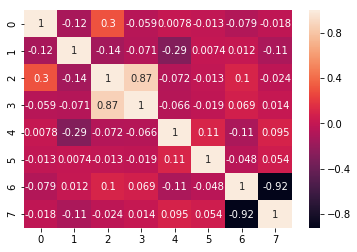

In [8]:
sns.heatmap(pd.DataFrame(S_train).corr(), annot=True)

Так и есть. Число обусловленности большое, и пар признаков (2, 3) и (6, 7) большая корреляция по модулю

Теперь сделаем как положено: с нормализацией и регуляризацией

In [9]:
scaler = StandardScaler()
S_train = scaler.fit_transform(S_train)
S_test = scaler.transform(S_test)

In [10]:
np.linalg.cond(S_train), np.linalg.cond(S_test)

(6.80476339464444, 41.81595447184944)

In [11]:
R.mean(), R.std()

(2.068558169089147, 1.1539282040412253)

In [12]:
alpha = 1

model = Ridge(alpha=alpha)

def fit_and_report(model):
    model.fit(S_train, R_train)
    R_pred = model.predict(S_train)
    print('train')
    print(f'r2: {r2_score(R_train, R_pred):.3f}')
    print(f'mse: {mean_squared_error(R_train, R_pred):.3f}')
    print()

    R_pred = model.predict(S_test)
    print('test')
    print(f'r2: {r2_score(R_test, R_pred):.3f}')
    print(f'mse: {mean_squared_error(R_test, R_pred):.3f}')
    
fit_and_report(model)

train
r2: 0.614
mse: 0.515

test
r2: 0.291
mse: 0.941


слабая регуляризация

In [13]:
alpha = 1e4

model = Ridge(alpha=alpha)

fit_and_report(model)

train
r2: 0.451
mse: 0.732

test
r2: 0.295
mse: 0.935


In [14]:
model = ElasticNet(alpha=2e-1)

fit_and_report(model)

train
r2: 0.485
mse: 0.687

test
r2: 0.461
mse: 0.716


In [15]:
model.coef_

array([ 0.64659438,  0.08152016, -0.        , -0.        ,  0.        ,
       -0.        , -0.01167054, -0.        ])

Используется только 3 признака

In [16]:
model = ElasticNet(alpha=1)

fit_and_report(model)

train
r2: 0.212
mse: 1.050

test
r2: 0.201
mse: 1.061


In [17]:
model.coef_

array([ 0.20151764,  0.        ,  0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        ])

Качество с L1 регуляризацией значительно лучше  
Этот гиперпараметр общий для всех моделей, поэтому не делаю отдельную валидацию

In [18]:
# plt.hist(R)

In [22]:
import torch
import torch.nn as nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [23]:
class RND:
    def __init__(self, target_net, predictor_net, optimizer, criterion=torch.nn.MSELoss()):
        self.target_net = target_net
        self.predictor_net = predictor_net
        self.optimizer = optimizer
        self.criterion = criterion
        self.X = torch.Tensor().to(device)
        
    def need_to_train(self, phi_tensor, tol=1e-3):
        '''
        train iff error on the new object is less than tol
        '''
        self.predictor_net.eval()
        target_pred = self.target_net(phi_tensor)
        predictor_pred = self.predictor_net(phi_tensor)
        loss = self.criterion(predictor_pred, target_pred).item()
        
        return loss > tol
    
    def choose_phi(self, Phi):
        '''
        choose phi with max target-predict error
        '''
        self.predictor_net.eval()
        Phi_tensor = torch.Tensor(Phi)
        target_pred = self.target_net(Phi_tensor)
        predictor_pred = self.predictor_net(Phi_tensor)
        errors = (target_pred - predictor_pred).abs()
        return torch.argmax(errors.squeeze()).cpu().detach().numpy()
        
    def fit(self, phi, tol=1e-1, batch_size=4, verbose=False):
        phi_tensor = torch.Tensor(phi).unsqueeze(0).to(device)
        self.X = torch.cat((self.X, phi_tensor))
        
        need_train_flg = self.need_to_train(phi_tensor)
        if need_train_flg:
            self.predictor_net.train()
            epoch_mse = np.inf
            while epoch_mse > tol:
                if verbose:
                    print('new training epoch...')
                epoch_mse = []
                permutation = torch.randperm(self.X.size()[0])
                for i in range(0, self.X.size()[0], batch_size):
                    batch_ind = permutation[i:i+batch_size]
                    batch = self.X[batch_ind]
                    
                    target_pred = self.target_net(batch)
                    predictor_pred = self.predictor_net(batch)
                    loss = self.criterion(predictor_pred, target_pred)
                    
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()
                    
                    epoch_mse += [loss.item()]
                    
                epoch_mse = np.mean(epoch_mse)
                if verbose:
                    print(epoch_mse)
                

def make_network(input_size=8):
    net = nn.Sequential(
        nn.Linear(input_size, 10),
        nn.ReLU(),
        nn.Linear(10, 1)
    )
    
    return net

lr = 5e-4

target_net = make_network()
predictor_net = make_network()

target_net.eval()

optimizer = torch.optim.Adam(predictor_net.parameters(), lr=lr)
rnd_model = RND(target_net, predictor_net, optimizer)

def create_rnd(lr=5e-4):
    target_net = make_network()
    predictor_net = make_network()

    target_net.eval()

    optimizer = torch.optim.Adam(predictor_net.parameters(), lr=lr)
    rnd_model = RND(target_net, predictor_net, optimizer)
    
    return rnd_model

In [24]:
# rnd_model.fit(S[0], verbose=True)

In [25]:
# rnd_model.fit(S[98], verbose=True)

In [26]:
train_cols = lambda df: df[[col for col in df.columns if 'train' in col]]
test_cols = lambda df: df[[col for col in df.columns if 'test' in col]]

,random_train,random_test,stat_volume_train,stat_volume_test,stacked_volume_train,stacked_volume_test,max_error_train,max_error_test,min_variance_train,min_variance_test,greedy_train,greedy_test,random_network_distill_train,random_network_distill_test
300,0.94,0.95,0.83,0.85,0.83,0.85,0.85,0.87,0.80,0.82,0.73,0.76,0.93,0.94
350,0.95,0.96,0.85,0.87,0.85,0.87,0.87,0.89,0.79,0.82,0.73,0.76,0.94,0.95
400,0.96,0.98,0.87,0.89,0.87,0.89,0.87,0.88,0.78,0.81,0.73,0.77,0.94,0.96
450,0.97,0.98,0.87,0.89,0.87,0.89,0.88,0.90,0.78,0.81,0.74,0.77,0.96,0.97
500,0.98,0.99,0.87,0.89,0.87,0.89,0.87,0.89,0.78,0.81,0.74,0.77,0.97,0.98


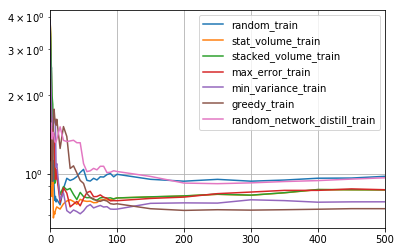

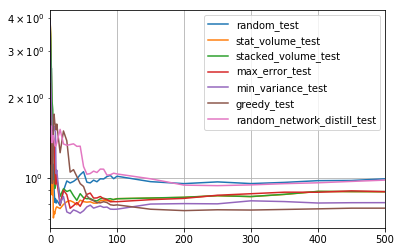

In [37]:

alpha = 1
n_iters = 501

methods = ['random', 'stat_volume', 'stacked_volume', 'max_error', 'min_variance', 'greedy']
agents = {method: Agent(method=method, linreg_model=ElasticNet(alpha)) for method in methods}
methods += ['random_network_distill']
agents['random_network_distill'] = Agent(method='random_network_distill', 
                                         linreg_model=ElasticNet(alpha),
                                         rnd_model=create_rnd(lr=5e-4))


eval_rule=lambda i: (i%500==0) or (i<1000 and i%50==0) or (i<100 and i%5==0) or (i<10)

global_scores, scores = run_experiment(agents, S_train, R_train, S_test, R_test,
                        n_iters=n_iters, n_repeats=1,
                       eval_rule=eval_rule, metric=mean_squared_error)

# plot_params = dict(logy=True, grid=True, ylim=(0, 1))
plot_params = dict(logy=True, grid=True)

train_cols(scores).plot(**plot_params)
test_cols(scores).plot(**plot_params)

display(scores.tail(5).round(2))

In [39]:
agents['random'].linreg_model.coef_, agents['min_variance'].linreg_model.coef_

(array([ 0.26408861,  0.        ,  0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        ]),
 array([ 0.60184032,  0.        ,  0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        ]))

**Результаты**:  
Большая регуляризация $\alpha=1$    
*RND* показывает качество на уровне рандома, mse ~ 1.0  
*stat_volume* лучше, mse ~ 0.9  
*max_error, min_variance, greedy* тоже показывают хорошие результаты, но они "нечестные" (используют будущий reward при выборе действия), они здесь есть для обогащения множества бенчмарков
Странно, что все кривые выходят на плато, но не сходятся в одну точку

Поставим регуляризацию, дающую лучшее качество на тесте

,random_train,stat_volume_train,stacked_volume_train,max_error_train,min_variance_train,greedy_train,random_network_distill_train
90,0.68,0.66,0.66,0.66,0.69,0.73,0.68
95,0.68,0.66,0.66,0.68,0.70,0.72,0.68
100,0.68,0.66,0.67,0.74,0.70,0.72,0.68
150,0.67,0.66,0.67,0.75,0.72,0.72,0.64
200,0.69,0.67,0.68,0.71,0.72,0.72,0.65


,random_test,stat_volume_test,stacked_volume_test,max_error_test,min_variance_test,greedy_test,random_network_distill_test
90,0.71,0.69,0.69,4.46,0.74,0.77,0.72
95,0.71,0.69,0.70,5.15,0.74,0.76,0.72
100,0.71,0.70,0.70,8.65,1.18,0.76,0.72
150,0.70,0.69,0.69,9.36,5.18,0.76,0.72
200,0.72,0.71,0.72,6.89,6.14,0.76,0.69


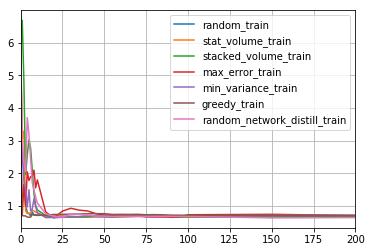

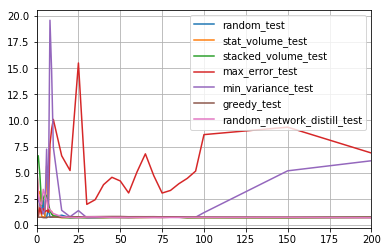

In [46]:
alpha = 2e-1
n_iters = 201

methods = ['random', 'stat_volume', 'stacked_volume', 'max_error', 'min_variance', 'greedy']
agents = {method: Agent(method=method, linreg_model=ElasticNet(alpha)) for method in methods}
methods += ['random_network_distill']
agents['random_network_distill'] = Agent(method='random_network_distill', 
                                         linreg_model=ElasticNet(alpha),
                                         rnd_model=create_rnd(lr=5e-4))


eval_rule=lambda i: (i%500==0) or (i<1000 and i%50==0) or (i<100 and i%5==0) or (i<10)

global_scores, scores = run_experiment(agents, S_train, R_train, S_test, R_test,
                        n_iters=n_iters, n_repeats=1,
                       eval_rule=eval_rule, metric=mean_squared_error)

# plot_params = dict(logy=True, grid=True, ylim=(0, 1))
plot_params = dict(logy=False, grid=True)

train_cols(scores).plot(**plot_params)
test_cols(scores).plot(**plot_params)

display(train_cols(scores).tail(5).round(2))
display(test_cols(scores).tail(5).round(2))

In [49]:
pd.DataFrame({method: agents[method].linreg_model.coef_ for method in methods}).T

,0,1,2,3,4,5,6,7
random,0.665105,0.012649,0.0,0.0,0.0,-0.000000,-0.105869,-0.000000
stat_volume,0.697392,0.095026,-0.0,-0.0,0.0,-0.021948,-0.167996,-0.000000
stacked_volume,0.704617,0.080873,-0.0,-0.0,0.0,-0.018862,-0.173952,-0.000000
max_error,0.678404,0.089317,-0.0,0.0,0.0,-0.316340,-0.225585,-0.103139
min_variance,0.872068,0.113630,-0.0,0.0,0.0,-0.297526,-0.209082,-0.000000
greedy,0.807542,0.144392,0.0,-0.0,-0.0,-0.000000,0.000000,-0.025374
random_network_distill,0.701520,0.148754,-0.0,0.0,0.0,-0.018376,-0.069712,-0.000000


Здесь совсем другие результаты  
*max_error* и *min_variance* почему-то плохо ведут себя на тесте  
остальные методы работают примерно как *random*  

,random_train,stat_volume_train,stacked_volume_train,max_error_train,min_variance_train,greedy_train,random_network_distill_train
300,1.29,1.27,1.28,1.28,1.29,1.25,1.37
350,1.29,1.27,1.27,1.25,1.25,1.23,1.36
400,1.28,1.26,1.26,1.25,1.25,1.23,1.36
450,1.27,1.25,1.25,1.25,1.25,1.22,1.35
500,1.27,1.23,1.24,1.22,1.22,1.21,1.34


,random_test,stat_volume_test,stacked_volume_test,max_error_test,min_variance_test,greedy_test,random_network_distill_test
300,1.29,1.27,1.27,1.27,1.28,1.24,1.36
350,1.29,1.26,1.27,1.24,1.25,1.23,1.35
400,1.28,1.25,1.26,1.24,1.24,1.22,1.35
450,1.27,1.24,1.25,1.25,1.25,1.21,1.34
500,1.27,1.23,1.23,1.21,1.21,1.20,1.34


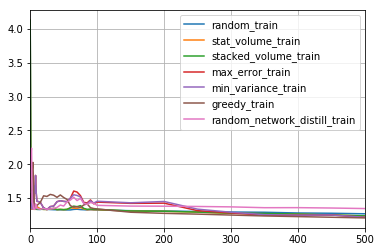

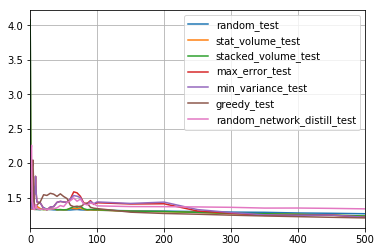

In [53]:
alpha = 1e4
n_iters = 501

methods = ['random', 'stat_volume', 'stacked_volume', 'max_error', 'min_variance', 'greedy']
agents = {method: Agent(method=method, linreg_model=Ridge(alpha)) for method in methods}
methods += ['random_network_distill']
agents['random_network_distill'] = Agent(method='random_network_distill', 
                                         linreg_model=ElasticNet(alpha),
                                         rnd_model=create_rnd(lr=5e-4))


eval_rule=lambda i: (i%500==0) or (i<1000 and i%50==0) or (i<100 and i%5==0) or (i<10)

global_scores, scores = run_experiment(agents, S_train, R_train, S_test, R_test,
                        n_iters=n_iters, n_repeats=1,
                       eval_rule=eval_rule, metric=mean_squared_error)

# plot_params = dict(logy=True, grid=True, ylim=(0, 1))
plot_params = dict(logy=False, grid=True)

train_cols(scores).plot(**plot_params)
test_cols(scores).plot(**plot_params)

display(train_cols(scores).tail(5).round(2))
display(test_cols(scores).tail(5).round(2))

# Мусор

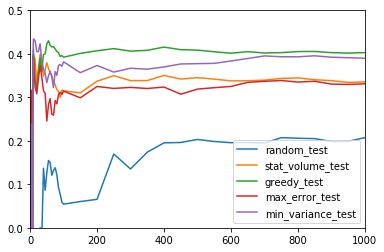

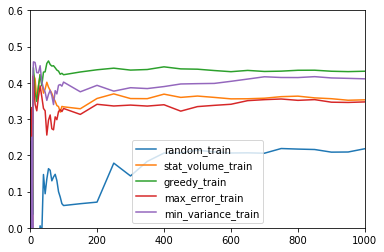

In [27]:
methods = ['random', 'stat_volume', 'greedy', 'max_error', 'min_variance']
agents = {method: Agent(method=method, linreg_model=ElasticNet(1e-0)) for method in methods}
eval_rule=lambda i: (i%500==0) or (i<1000 and i%50==0) or (i<100 and i%5==0) or (i<10)

global_scores, scores = run_experiment(agents, S_train, R_train, S_test, R_test,
                        n_iters=1001, n_repeats=1,
                       eval_rule=eval_rule)

scores[[col for col in scores.columns if 'test' in col]].plot(ylim=(0,0.5))
scores[[col for col in scores.columns if 'train' in col]].plot(ylim=(0,0.6))